## Data Correlation
For each columns used in the paper we calculate Spearman correlation for each posible pair 

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 10]

In [7]:
%cd ..

/home/belu/VS Workplace/2021-re-pendleton-perovskite


In [8]:
import src.data.notebook_utils as utils

results = 'notebooks/results/correlation/'

df = utils.read_data()

columns_by_type = utils.get_columns(df.columns)
used_data = utils.get_used_columns(df.columns)
selected_columns = set()

In [9]:
selected_columns = selected_columns.union(columns_by_type['_feat_'],columns_by_type['solUD'],columns_by_type['chem'])

In [10]:
len(selected_columns)

111

In [11]:
for key, cols in columns_by_type.items():
    print('#Cols for type {}: {}'.format(key, len(cols)))

#Cols for type _rxn_: 9
#Cols for type _feat_: 67
#Cols for type solUD: 8
#Cols for type chem: 36


In [12]:
columns_by_type.keys()

dict_keys(['_rxn_', '_feat_', 'solUD', 'chem'])

All columns are numeric

A bit more about raw_reagent information to be considered:

For each reagent precursor (not all of them), there are +/-:
-   Concentration of each compounds used: by inchikey NOT USED FOR STD. Ex _raw_reagent_2_conc_QNNYEDWTOZODAS-UHFFFAOYSA-N'
-   instructions (duration, volume, volumen units, etc) Ex _raw_reagent_2_instructions_0_duration_units'
-   Concentration for SolUD ("_v1-") Ex'_raw_reagent_2_v1-conc_BAMDIFIROXTEEM-UHFFFAOYSA-N
-   Volume in total Ex _raw_reagent_2_volume
-   Amount of each chemical c Ex_raw_reagent_3_chemicals_0_actual_amount 

'_raw_smiles','_raw_smiles_standard',
 '_raw_standard_molweight',
 '_raw_standardized_smiles',
 '_raw_temperatureC_nominal',
 '_raw_timecompleted_UTC',
 '_raw_timecreated_UTC',
 '_raw_v0-M_acid',
 '_raw_v0-M_inorganic',
 '_raw_v0-M_organic',

 +
 _raw_v1-mmol
 _raw_v1-M

### Pearson Correlaation
First we should check if our data has a Normal distribution.

In [13]:
import scipy.stats as stats
import numpy as np 

In [14]:
normal_cols = 0
column_normalization = dict()
for column in selected_columns:
    value = round(stats.normaltest(df[column])[1], 4)
    if (value >= 0.05):
        print(column)
        normal_cols+=1

_feat_maximalprojectionsize
_feat_LengthPerpendicularToTheMaxArea


From only two columns there are enough evidence to affirm that its data don't belong to a non-normal distribution.

### Spearman Correlation
Decied to move on with this kind of correlation because it does not assume any specific distribution

In [15]:
import itertools as it 
import numpy as np

combinations = np.array(list(it.combinations(selected_columns, 2)))

In [16]:
final_df = df[selected_columns]

In [17]:
len(final_df)

6241

In [18]:
spearman_corr = final_df.corr('spearman')

In [19]:
spearman_correlation = np.zeros(combinations.shape[0])
for i, pair in enumerate(combinations):
    spearman_correlation[i] = spearman_corr[pair[0]][pair[1]]

In [20]:
sort_index = np.argsort(spearman_correlation)
spearman_correlation = spearman_correlation[sort_index]
combinations = combinations[sort_index]

In [21]:
correlations = pd.DataFrame(combinations)
correlations['correlation'] = spearman_correlation
correlations.sort_values(['correlation'],ascending=False)
correlations.dropna(inplace=True)
correlations.rename({0:'column1', 1:'column2'}, inplace=True, axis=1)

In [22]:
correlations.sort_values(['correlation'],ascending=False).to_csv(results+'feat_correlations_spearman.csv', index=None)


In [23]:
correlations_plot = correlations.sort_values(['correlation'],ascending=False)


In [24]:
len(correlations_plot)

3486

### Spearman Correlation - by Plotly

In [25]:
# sns.heatmap(data_corr, xticklabels=columns,yticklabels=columns,cmap='RdBu_r',annot=False)'''

In [34]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.offline as pyo

from scipy.spatial.distance import pdist, squareform

import scipy.cluster.hierarchy as sch

def corr_heatmap(numpy_array, columns):
    data_array = numpy_array
    labels = columns
    colorScale = 'default'
    dendogramMethod='median'
   
    # Initialize figure by creating upper dendrogram
    #fig = ff.create_dendrogram(data_array, orientation='bottom', linkagefun=lambda x: sch.linkage(x, method=dendogramMethod, metric=distanceMethod ,optimal_ordering=True), labels=labels)
    fig = ff.create_dendrogram(data_array, orientation='bottom', linkagefun=lambda x: sch.linkage(x, method=dendogramMethod, optimal_ordering=True), labels=labels)
    for i in range(len(fig['data'])):
        fig['data'][i]['yaxis'] = 'y2'

    # Create Side Dendrogram
    #dendro_side = ff.create_dendrogram(data_array, orientation='right', linkagefun=lambda x: sch.linkage(x, method=dendogramMethod, metric=distanceMethod,  optimal_ordering=True) )
    dendro_side = ff.create_dendrogram(data_array, orientation='right', linkagefun=lambda x: sch.linkage(x, method=dendogramMethod, optimal_ordering=True) )

    for i in range(len(dendro_side['data'])):
        dendro_side['data'][i]['xaxis'] = 'x2'

    # Add Side Dendrogram Data to Figure
    # ~ stack1 = []
    for data in dendro_side['data']:
        fig.add_trace(data)


    # Create Heatmap
    dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
    dendro_leaves = list(map(int, dendro_leaves))
    heat_data = data_array
    heat_data = heat_data[dendro_leaves,:]
    heat_data = heat_data[:,dendro_leaves]

    if(colorScale!='default'):
        aux=go.Heatmap(
            x = dendro_leaves,
            y = dendro_leaves,
            z = heat_data,
            colorscale = colorScale,
            colorbar=dict(title='Trie distances'),
            )
        heatmap = [aux]
    else:
        aux = go.Heatmap(
            x=dendro_leaves,
            y=dendro_leaves,
            z=heat_data,
            colorbar=dict(title='Trie distances'),
        )
        heatmap = [aux]
        # heatmap = [
        # 	go.Heatmap(
        # 		x = dendro_leaves,
        # 		y = dendro_leaves,
        # 		z = heat_data
        # 	)
        # ]
	
    heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
    heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']

    # Add Heatmap Data to Figure
    for data in heatmap:
        fig.add_trace(data)


    # Edit Layout
    fig.update_layout({'width':800, 'height':800,
                            'showlegend':False, 'hovermode': 'closest',
                            })
    # Edit xaxis
    fig.update_layout(xaxis={'domain': [.15, 1],
                                    'mirror': False,
                                    'showgrid': False,
                                    'showline': False,
                                    'zeroline': False,
                                    'ticks':""})
    # Edit xaxis2
    fig.update_layout(xaxis2={'domain': [0, .15],
                                    'mirror': False,
                                    'showgrid': False,
                                    'showline': False,
                                    'zeroline': False,
                                    'showticklabels': False,
                                    'ticks':""})

    # Edit yaxis
    fig.update_layout(yaxis={'domain': [0, .85],
                                    'mirror': False,
                                    'showgrid': False,
                                    'showline': False,
                                    'zeroline': False,
                                    'showticklabels': False,
                                    'ticks': ""
                            })
    # Edit yaxis2
    fig.update_layout(yaxis2={'domain':[.825, .975],
                                    'mirror': False,
                                    'showgrid': False,
                                    'showline': False,
                                    'zeroline': False,
                                    'showticklabels': False,
                                    'ticks':""})
    # ~ print(fig)
    fig['layout']['yaxis']['ticktext'] = fig['layout']['xaxis']['ticktext']
    fig['layout']['yaxis']['tickvals'] = fig['layout']['xaxis']['tickvals']


    #fig.show()

    pyo.iplot(fig, filename='test')

In [35]:
feat_col = list(columns_by_type['_feat_'])

In [36]:
def plot_corr_dendogram(df, columns):
    df_feat = df[columns]
    df_feat_noctes = df_feat.loc[:, (df_feat != df_feat.iloc[0]).any()] 
    df_feat_cols = df_feat_noctes.columns
    corr_df = df_feat_noctes.corr(method='spearman').values
    corr_heatmap(corr_df, df_feat_cols)
     

In [ ]:
columns = list(columns_by_type['_feat_'])
df_feat = df[columns]
df_feat_noctes = df_feat.loc[:, (df_feat != df_feat.iloc[0]).any()] 
df_feat_cols = df_feat_noctes.columns
corr_df = df[df_feat_cols].corr(method='spearman')
#corr_heapmap(corr_df, df_feat_cols)

In [37]:
pyo.init_notebook_mode(connected=True)
link = plot_corr_dendogram(final_df, list(columns_by_type['_feat_']))

In [ ]:
link

In [108]:
plot_corr_dendogram(final_df, list(columns_by_type['solUD']))

In [96]:
df_feat = final_df[feat_col]
df_feat_noctes = df_feat.loc[:, (df_feat != df_feat.iloc[0]).any()] 
df_feat_cols = df_feat_noctes.columns

In [97]:
corr_df = final_df[df_feat_cols].corr(method='spearman')

In [103]:
corr_df.head()

,_feat_HeteroaliphaticRingCount,_feat_acceptorcount,_feat_WienerPolarity,_feat_ASA_H,_feat_ChainAtomCount,_feat_AtomCount_C,_feat_BondCount,_feat_LengthPerpendicularToTheMaxArea,_feat_molsurfaceareaVDWp,_feat_CarboaliphaticRingCount,...,_feat_MaximalProjectionRadius,_feat_LargestRingSize,_feat_Protpsa,_feat_HyperWienerIndex,_feat_AromaticAtomCount,_feat_msareaVDWp,_feat_Hacceptorcount,_feat_AvgPol,_feat_MinimalProjectionRadius,_feat_CyclomaticNumber
_feat_HeteroaliphaticRingCount,1.000000,0.260480,-0.144515,-0.280714,-0.308383,0.027794,-0.112287,-0.223153,-0.266321,-0.022268,...,-0.227986,0.261662,-0.337339,0.045602,-0.079851,-0.266321,0.260480,0.009246,-0.049832,0.342021
_feat_acceptorcount,0.260480,1.000000,-0.303277,-0.585440,-0.024917,-0.410217,-0.452284,-0.588056,-0.582171,-0.076793,...,-0.559694,0.008248,0.759409,-0.052099,-0.061424,-0.582171,1.000000,-0.288643,0.031020,0.030760
_feat_WienerPolarity,-0.144515,-0.303277,1.000000,0.780542,0.387843,0.909609,0.888485,0.509524,0.867400,0.156529,...,0.892008,0.630997,-0.221151,0.906605,0.675832,0.867400,-0.303277,0.892169,0.750277,0.601736
_feat_ASA_H,-0.280714,-0.585440,0.780542,1.000000,0.436258,0.853802,0.917796,0.832469,0.949312,0.107602,...,0.936676,0.264706,-0.426290,0.684447,0.350430,0.949312,-0.585440,0.821341,0.566283,0.233225
_feat_ChainAtomCount,-0.308383,-0.024917,0.387843,0.436258,1.000000,0.368617,0.508423,0.514649,0.493292,-0.184160,...,0.404651,-0.305200,0.129436,0.507544,-0.152347,0.493292,-0.024917,0.477808,0.440229,-0.324058


In [93]:
#corr_df = corr_df.dropna(axis='columns')

In [104]:
corr_heapmap(corr_df, df_feat_cols)

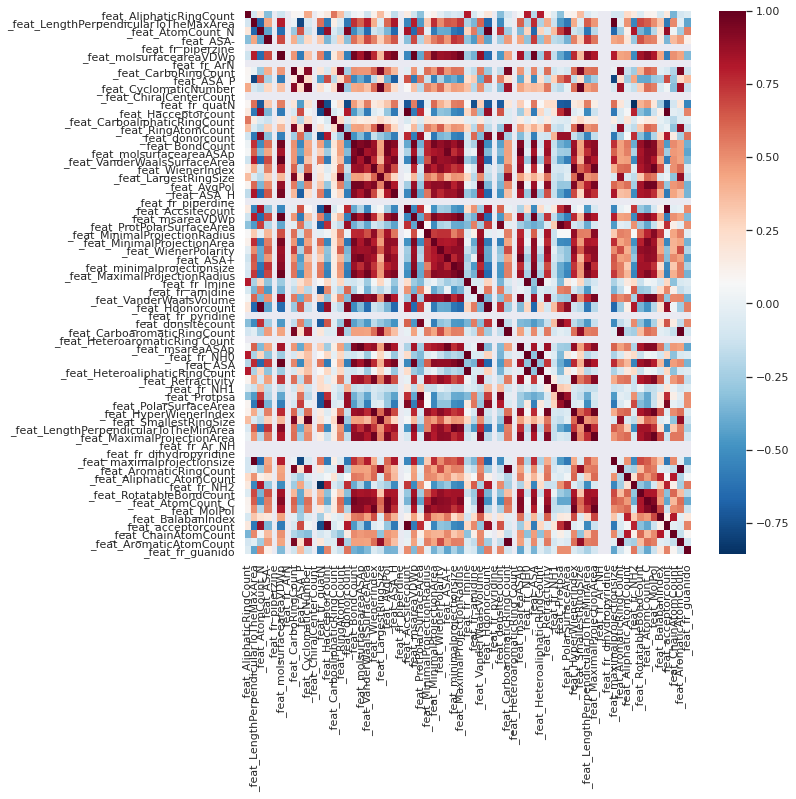

In [29]:
corr_heapmap(df, list(columns_by_type['_feat_'])) #dendograma

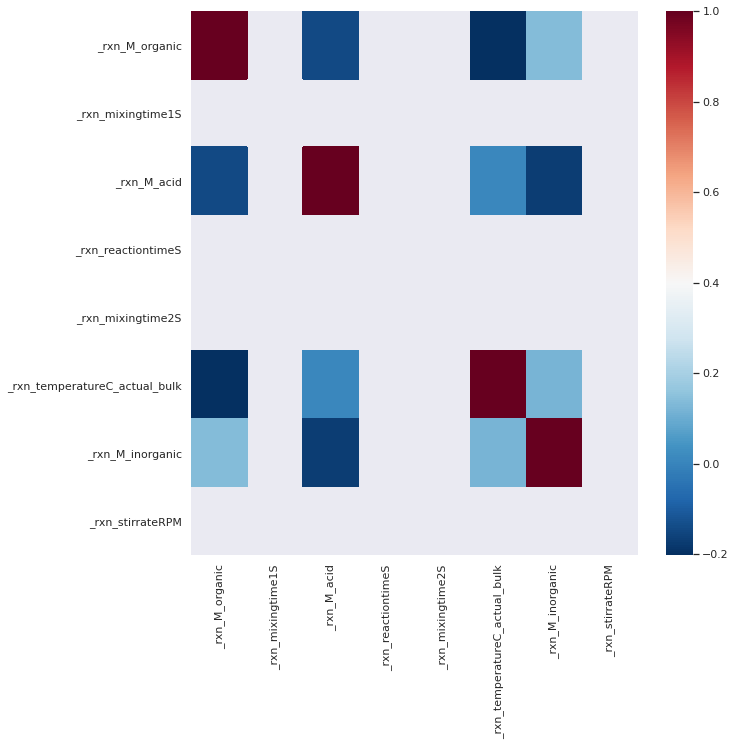

In [42]:
corr_heapmap(df, list(columns_by_type['solUD']))

OBS: There are 4 constant columns in _rxn_ type

In [52]:
df['_rxn_temperatureC_actual_bulk'].value_counts()

95.0     4876
67.0      737
83.0       96
110.0      96
85.0       96
122.0      96
80.0       96
105.0      64
70.0       60
94.0       24
Name: _rxn_temperatureC_actual_bulk, dtype: int64

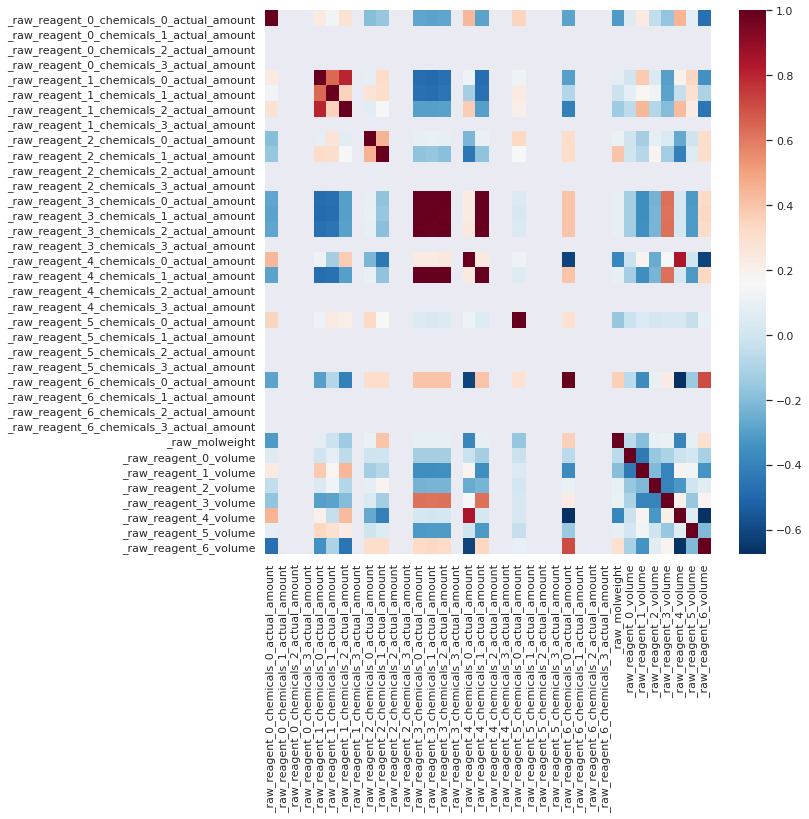

In [7]:
corr_heapmap(df, list(columns_by_type['chem']))

In [388]:
df = correlations_plot[(correlations_plot['correlation'] > -0.0001) & (correlations_plot['correlation'] < 0.0001)]


In [389]:
subset_columns = set(df['column1']).union(set(df['column2']))
len(subset_columns)

2

In [396]:
abs_corr_upper_bound = 0.05 #300 col
abs_corr_lower_bound = 0.0001 #300 col

In [411]:
steps = np.linspace(abs_corr_lower_bound,abs_corr_upper_bound,10)**2
steps

array([1.00000000e-08, 3.18597531e-05, 1.25191235e-04, 2.80004444e-04,
       4.96299383e-04, 7.74076049e-04, 1.11333444e-03, 1.51407457e-03,
       1.97629642e-03, 2.50000000e-03])

In [497]:
def look_for_interval_for(abs_corr_lower_bound, abs_corr_upper_bound):
    #abs_corr_upper_bound = 0.05 #300 col
    #abs_corr_lower_bound = 0.0001 #300 col
    steps = np.linspace(abs_corr_lower_bound,abs_corr_upper_bound,15)**2
    independent_k_first_columns = {}
    #number_ind_col = np.zeros(steps.shape[0])
    for i, step in enumerate(steps):
        df = correlations_plot[(correlations_plot['correlation'] > -step) & (correlations_plot['correlation'] < step)]
        subset_columns = set(df['column1']).union(set(df['column2']))
        #number_ind_col[i,] = len(subset_columns)
        independent_k_first_columns[len(subset_columns)] = subset_columns
    return independent_k_first_columns

In [526]:
independent_k_first_columns = look_for_interval_for(0.012, 0.1)
independent_k_first_columns.keys()

dict_keys([11, 27, 56, 75, 80, 96, 115, 141, 165, 189, 210, 218, 235, 270, 277])

FIrst 19 ind. columns

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = [10, 10]

,_raw_reagent_1_v1-conc_RQQRAHKHDFPBMC-UHFFFAOYSA-L,_raw_reagent_2_v1-conc_QNNYEDWTOZODAS-UHFFFAOYSA-N,_raw_reagent_1_v1-conc_QNNYEDWTOZODAS-UHFFFAOYSA-N,_raw_M_RQQRAHKHDFPBMC-UHFFFAOYSA-L_final,_raw_M_QNNYEDWTOZODAS-UHFFFAOYSA-N_final,_raw_reagent_1_conc_QNNYEDWTOZODAS-UHFFFAOYSA-N,_raw_reagent_2_conc_GIAPQOZCVIEHNY-UHFFFAOYSA-N,_raw_v1-M_RQQRAHKHDFPBMC-UHFFFAOYSA-L_final,_raw_reagent_2_conc_QNNYEDWTOZODAS-UHFFFAOYSA-N,_feat_CarboRingCount,_raw_reagent_1_volume,_raw_M_FCTHQYIDLRRROX-UHFFFAOYSA-N_final,_raw_reagent_1_v1-conc_GIAPQOZCVIEHNY-UHFFFAOYSA-N,_raw_reagent_2_v1-conc_GIAPQOZCVIEHNY-UHFFFAOYSA-N,_rxn_M_inorganic,_feat_fr_NH1,_raw_reagent_1_conc_GIAPQOZCVIEHNY-UHFFFAOYSA-N,_raw_v1-M_QNNYEDWTOZODAS-UHFFFAOYSA-N_final,_raw_v0-M_inorganic
0,1.589766,-0.12499,-0.12499,-0.831850,-0.117151,-0.12499,-0.12499,-0.852949,-0.12499,2.115316,-0.901896,-0.193788,-0.12499,-0.12499,-0.852949,-0.229396,-0.12499,-0.117218,-0.831850
1,1.589766,-0.12499,-0.12499,1.438464,-0.117151,-0.12499,-0.12499,1.500379,-0.12499,2.115316,1.257782,-0.193788,-0.12499,-0.12499,1.500379,-0.229396,-0.12499,-0.117218,1.438464
2,1.589766,-0.12499,-0.12499,1.033106,-0.117151,-0.12499,-0.12499,1.080198,-0.12499,2.115316,0.646427,-0.193788,-0.12499,-0.12499,1.080198,-0.229396,-0.12499,-0.117218,1.033106
3,1.589766,-0.12499,-0.12499,-0.773293,-0.117151,-0.12499,-0.12499,-0.792251,-0.12499,2.115316,-0.888606,-0.193788,-0.12499,-0.12499,-0.792251,-0.229396,-0.12499,-0.117218,-0.773293
4,1.589766,-0.12499,-0.12499,0.958775,-0.117151,-0.12499,-0.12499,1.003150,-0.12499,2.115316,0.566685,-0.193788,-0.12499,-0.12499,1.003150,-0.229396,-0.12499,-0.117218,0.958775


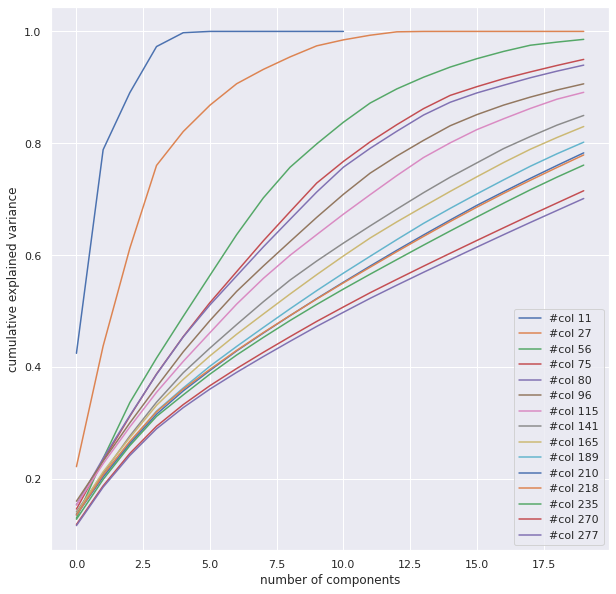

In [524]:
keys_legend = ['#col '+ str(i) for i in independent_k_first_columns.keys()]
for key, independent_cols in independent_k_first_columns.items():
    scaler = StandardScaler()
    std_df =pd.DataFrame(scaler.fit_transform(final_df[list(independent_cols)]), columns=list(independent_cols))
    #std_df.head()
    pca, pca_df = apply_pca(std_df)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
plt.legend(keys_legend)


In [7]:
def apply_pca(std_df,n_components):
    pca_number = min(len(std_df.columns), n_components)
    pca_columns = ['PCA_'+ str(n) for n in range(pca_number)]
    pca = PCA(n_components=pca_number, svd_solver = 'auto')
    Principal_components=pca.fit_transform(std_df)
    pca_df = pd.DataFrame(data = Principal_components, columns = pca_columns)
    return pca, pca_df 
    #print(pca_df)

In [528]:
independent_cols =  independent_k_first_columns[27]

In [529]:
std_df = final_df[independent_cols] 

In [530]:
pca_number = min(len(std_df.columns), 20)
pca_columns = ['PCA_'+ str(n) for n in range(pca_number)]
pca = PCA(n_components=pca_number, svd_solver = 'auto')
Principal_components=pca.fit_transform(std_df)
pca_df = pd.DataFrame(data = Principal_components, columns = pca_columns)

In [534]:
loadings = pd.DataFrame(pca.components_.T, columns=pca_columns, index=independent_cols)
loadings.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19
_raw_reagent_1_v1-conc_RQQRAHKHDFPBMC-UHFFFAOYSA-L,0.000154,0.020608,-0.023857,0.012376,-0.022510,0.028547,0.283030,-0.059207,0.188726,-0.842936,-0.409406,-0.000159,0.010133,-0.006615,-0.000283,0.000072,1.257540e-14,-0.000000e+00,0.000000e+00,-0.000000e+00
_raw_reagent_2_v1-conc_QNNYEDWTOZODAS-UHFFFAOYSA-N,-0.000092,-0.002307,-0.005915,-0.015597,-0.123496,0.376598,-0.104364,-0.036105,0.089618,0.006146,-0.005565,0.165611,-0.003985,-0.003676,0.000027,-0.000393,-8.897739e-01,3.555747e-03,-2.465354e-02,1.116536e-02
_raw_M_RQQRAHKHDFPBMC-UHFFFAOYSA-L_final,0.002142,0.003693,0.011267,-0.013346,-0.091704,0.046847,0.473127,-0.267851,0.116971,0.190567,0.028077,0.002355,-0.026007,0.376843,0.000113,-0.000374,-4.355028e-02,-3.024462e-02,3.088150e-01,-1.045512e-01
_raw_M_QNNYEDWTOZODAS-UHFFFAOYSA-N_final,-0.000056,-0.001672,-0.000857,-0.011174,-0.092813,0.270928,-0.074248,-0.025407,0.066636,0.004137,-0.001223,-0.775852,0.017177,0.001343,-0.000882,-0.552264,-7.052735e-17,-9.556147e-16,1.492879e-16,1.170703e-15
_raw_reagent_2_conc_KFQARYBEAKAXIC-UHFFFAOYSA-N,-0.000071,-0.000330,-0.014536,-0.005067,0.001861,0.016375,0.105426,0.302635,0.172313,0.046449,0.011549,-0.002214,-0.128098,-0.005241,-0.004053,-0.000016,1.288929e-02,1.351348e-01,2.302859e-02,1.649111e-01


In [543]:
pca_columns_k = ['PCA_'+ str(n) for n in range(5)]


In [546]:
loadings[pca_columns_k].idxmax(axis = 0)

PCA_0                              _raw_reagent_1_volume
PCA_1           _raw_reagent_1_chemicals_1_actual_amount
PCA_2                                  _raw_v0-M_organic
PCA_3    _raw_reagent_2_conc_GIAPQOZCVIEHNY-UHFFFAOYSA-N
PCA_4           _raw_M_FCTHQYIDLRRROX-UHFFFAOYSA-N_final
dtype: object

<AxesSubplot:>

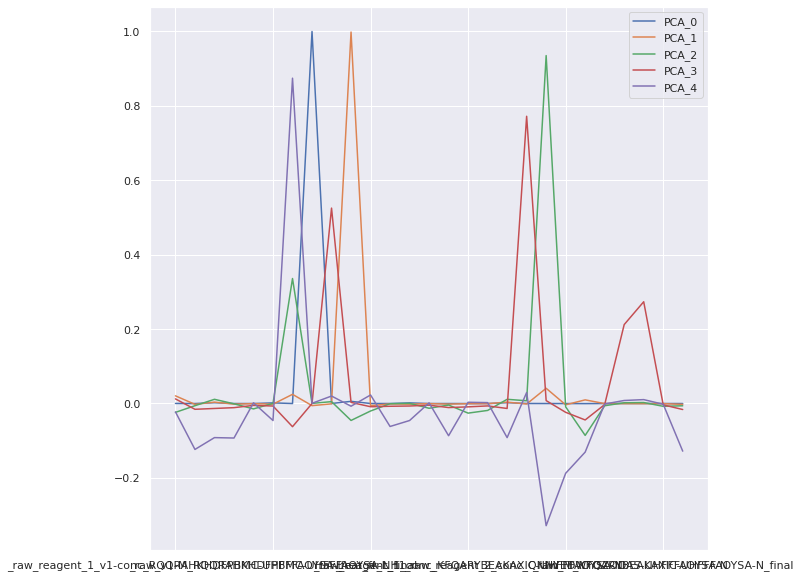

In [544]:
loadings[pca_columns_k].plot()

Text(0, 0.5, 'cumulative explained variance')

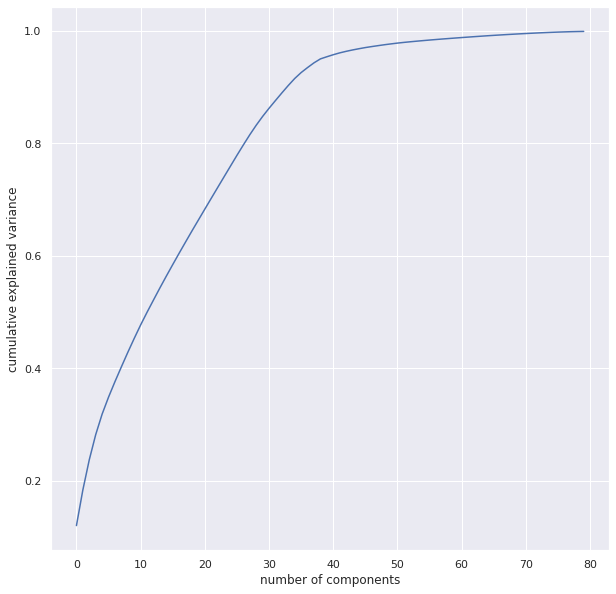

In [15]:
final_df = df
independent_cols = selected_columns
scaler = StandardScaler()
std_df =pd.DataFrame(scaler.fit_transform(final_df[list(independent_cols)]), columns=list(independent_cols))
#std_df.head()
pca, pca_df = apply_pca(std_df,80)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

<AxesSubplot:>

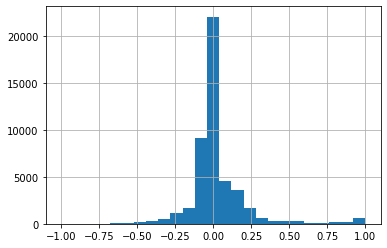

In [356]:
correlations_plot['correlation'].hist(bins=25)

In [ ]:
indepent_columns_count = [15,40,80,120]

In [286]:
correlations_plot

256    26.504454
257    26.504454
258    26.504454
259    26.504454
260    26.504454
Name: _raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N, dtype: float64

<AxesSubplot:>

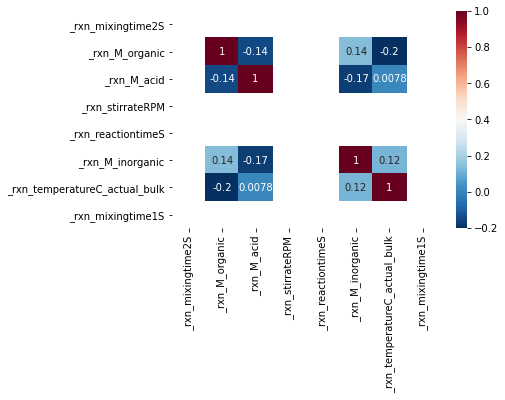

In [121]:
data_2 = df[list(columns_by_prefix[0])].corr('spearman')
sns.heatmap(data_2, 
            xticklabels=data_2.columns,
            yticklabels=data_2.columns,
            cmap='RdBu_r',
            annot=True)

In [257]:
combinations

array([['_raw_reagent_1_conc_FCTHQYIDLRRROX-UHFFFAOYSA-N',
        '_rxn_M_organic'],
       ['_raw_reagent_1_conc_FCTHQYIDLRRROX-UHFFFAOYSA-N',
        '_raw_v1-M_WGYRINYTHSORGH-UHFFFAOYSA-N_final'],
       ['_raw_reagent_1_conc_FCTHQYIDLRRROX-UHFFFAOYSA-N',
        '_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOYSA-N'],
       ...,
       ['_raw_reagent_2_chemicals_0_actual_amount',
        '_raw_reagent_2_v1-conc_JMXLWMIFDJCGBV-UHFFFAOYSA-N'],
       ['_raw_reagent_2_chemicals_0_actual_amount',
        '_raw_reagent_4_v1-conc_ZMXDDKWLCZADIW-UHFFFAOYSA-N'],
       ['_raw_reagent_2_v1-conc_JMXLWMIFDJCGBV-UHFFFAOYSA-N',
        '_raw_reagent_4_v1-conc_ZMXDDKWLCZADIW-UHFFFAOYSA-N']],
      dtype='<U50')

In [278]:
spearman_correlation

array([-1.        , -1.        , -0.98288077, ...,         nan,
               nan,         nan])

In [280]:
spearman_correlation

array([-1.        , -1.        , -0.98288077, ...,         nan,
               nan,         nan])

,0,1,correlation
46664,_raw_reagent_2_conc_NLJDBTZLVTWXRG-UHFFFAOYSA-N,_raw_reagent_1_v1-conc_NLJDBTZLVTWXRG-UHFFFAOY...,1.0
46560,_raw_reagent_1_v1-conc_ZEVRFFCPALTVDN-UHFFFAOY...,_raw_reagent_2_conc_ZEVRFFCPALTVDN-UHFFFAOYSA-N,1.0
46532,_raw_reagent_2_conc_NOHLSFNWSBZSBW-UHFFFAOYSA-N,_raw_reagent_1_conc_NOHLSFNWSBZSBW-UHFFFAOYSA-N,1.0
46531,_raw_reagent_2_conc_VNAAUNTYIONOHR-UHFFFAOYSA-N,_raw_reagent_2_v1-conc_VNAAUNTYIONOHR-UHFFFAOY...,1.0
46530,_raw_reagent_2_v1-conc_NXRUEVJQMBGVAT-UHFFFAOY...,_raw_reagent_1_conc_NXRUEVJQMBGVAT-UHFFFAOYSA-N,1.0
...,...,...,...
105106,_feat_ASA_H,_raw_reagent_2_chemicals_3_actual_amount,NaN
105107,_feat_ASA_H,_raw_reagent_1_conc_LCTUISCIGMWMAT-UHFFFAOYSA-N,NaN
105108,_feat_ASA_H,_raw_reagent_1_conc_QZCGFUVVXNFSLE-UHFFFAOYSA-N,NaN
105109,_raw_v1-M_BAMDIFIROXTEEM-UHFFFAOYSA-N_final,_raw_v1-M_NXRUEVJQMBGVAT-UHFFFAOYSA-N_final,NaN


In [266]:
correlations.head()

,0,1,correlation
0,_raw_reagent_4_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,_raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,-1.000000
1,_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,-1.000000
2,_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_6_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,-0.982881
3,_raw_reagent_6_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_4_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,-0.982881
4,_feat_fr_NH2,_feat_fr_quatN,-0.858166


In [273]:
correlations

,column1,column2,correlation
0,_raw_reagent_4_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,_raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,1.000000
1,_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,1.000000
2,_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_6_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,0.982881
3,_raw_reagent_6_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_4_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,0.982881
4,_feat_fr_NH2,_feat_fr_quatN,0.858166
...,...,...,...
46660,_raw_reagent_2_conc_JBOIAZWJIACNJF-UHFFFAOYSA-N,_raw_reagent_2_v1-conc_JBOIAZWJIACNJF-UHFFFAOY...,1.000000
46661,_raw_reagent_1_v1-conc_KFQARYBEAKAXIC-UHFFFAOY...,_raw_reagent_1_conc_KFQARYBEAKAXIC-UHFFFAOYSA-N,1.000000
46662,_feat_VanderWaalsSurfaceArea,_feat_molsurfaceareaVDWp,1.000000
46663,_raw_reagent_2_v1-conc_NXRUEVJQMBGVAT-UHFFFAOY...,_raw_reagent_1_conc_NXRUEVJQMBGVAT-UHFFFAOYSA-N,1.000000


In [268]:
correlations['correlation'] = correlations['correlation'].apply(lambda x: abs(x))

In [269]:
correlations.to_csv('abs_pair_correlations_spearman.csv', index=None)

In [270]:
correlations.sort_values(['correlation'],ascending=False)

,column1,column2,correlation
0,_raw_reagent_4_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,_raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,1.000000
1,_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,1.000000
2,_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_6_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,0.982881
3,_raw_reagent_6_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_4_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,0.982881
4,_feat_fr_NH2,_feat_fr_quatN,0.858166
...,...,...,...
46660,_raw_reagent_2_conc_JBOIAZWJIACNJF-UHFFFAOYSA-N,_raw_reagent_2_v1-conc_JBOIAZWJIACNJF-UHFFFAOY...,1.000000
46661,_raw_reagent_1_v1-conc_KFQARYBEAKAXIC-UHFFFAOY...,_raw_reagent_1_conc_KFQARYBEAKAXIC-UHFFFAOYSA-N,1.000000
46662,_feat_VanderWaalsSurfaceArea,_feat_molsurfaceareaVDWp,1.000000
46663,_raw_reagent_2_v1-conc_NXRUEVJQMBGVAT-UHFFFAOY...,_raw_reagent_1_conc_NXRUEVJQMBGVAT-UHFFFAOYSA-N,1.000000


In [225]:
df['_raw_M_FJFIJIDZQADKEE-UHFFFAOYSA-N_final'].value_counts()

0.000000    6146
1.113352       4
0.828153       4
0.194150       4
0.923219       3
            ... 
0.172586       1
0.795418       1
0.944815       1
1.001404       1
0.818313       1
Name: _raw_M_FJFIJIDZQADKEE-UHFFFAOYSA-N_final, Length: 81, dtype: int64

In [276]:
from pathlib import Path

full_plot_path = folder_replicated_results + 'plots/'
Path(full_plot_path).mkdir(parents=True, exist_ok=True)